# Sistema de Reconocimiento y Detección de Placas de Automóviles
El reconocimiento óptico de caracteres, u OCR por sus siglas en ingles (Optical Character Recognition), consiste en la transcipcion de texto identificado en imagenes. Esta tecnologia puede usarse en una amplia gama de aplicaciones para automtizar diversas tareas, como lo son la recoleccion de informacion a partir de imagenes de facturas o documentos escaneados, la transcripcion automatica de texto o la identificacion de senalamiento de anuncios viales.

En este respositorio se implemente un sistema de visión artificial para la detección automática de placas vehiculares y la identificación de caracteres mediante técnicas de OCR, orientado a automatizar procesos de control vehicular.

El proyecto se implemento en python, usando las siguientes librerias:
- OpenCV para el manejo y procesamiento de imagenes.
- Yolo-v4 para a la tarea de deteccion de las placas de automoviles.
- TeseractOCR para la extraccion de texto de las placas detectadas.

## Diseno del modelo
En primer lugar, se cargan los pesos y configuracion del modelo preentrenado Yolo-v4. En este caso se uso la version ALPR-with-Yolo-v4 implementada en el repositorio [anpr-with-yolo-v4](https://github.com/Dodant/anpr-with-yolo-v4), la cual esta enfocada en la deteccion de vehiculos y placas.

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pytesseract

# configuracion de pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'

# configuracion del modelo
weights_path = 'yolo_v4/yolov4-obj.weights'
configuration_path = 'yolo_v4/yolov4-obj.cfg'
network = cv2.dnn.readNetFromDarknet(configuration_path, weights_path)

# nombres de las 3 capas de prediccion, cada una enfocada en la deteccion de objetos
# en escala: pequeno, mediano y grande
outputs = ['yolo_139', 'yolo_150', 'yolo_161']

Posteriormente se carga la imagen de entrada:

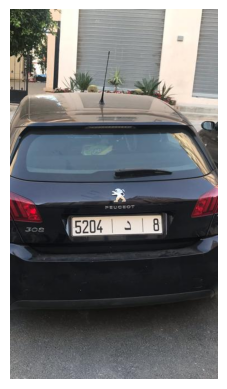

In [5]:
# lectura de imagen
image_input = cv2.imread('imgs/car1.jpg')
h, w = image_input.shape[0:2] # dimensions de la imagen

# plot
plt.imshow(cv2.cvtColor(image_input, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

A continuacion se realiza el preprocesamiento necesario para la evaluacion de la imagen de entrada en el modelo Yolo-v4:

In [6]:
# Normalizacion, redimension 416, 416 e intercambio de canales Red y Blue
blob = cv2.dnn.blobFromImage(image_input, 1 / 255.0, (416, 416), swapRB=True, crop=False)

Se realiza la prediccion del modelo sobre la imagen de entrada preprocesada. Como resultado Yolo-v4 devuelve un conjunto de posibles objetos detectados en la imagen, su posicion y la probabilidad de que la imagen pertenezca a la clase detectada. Cabe mencionar que el modelo devuelve 3 tipos de predicciones, pertenecientes a imagenes en escala pequena, mediana y grande. Por lo cual se opto por utilizar unicamente la prediccion con el mayor porcentaje de certeza de pertenecer a la clase `license_plate`.

Una vez que se ha identificado dicha prediccion, se extrae el contenido de la region de la region de interes para su analisis.

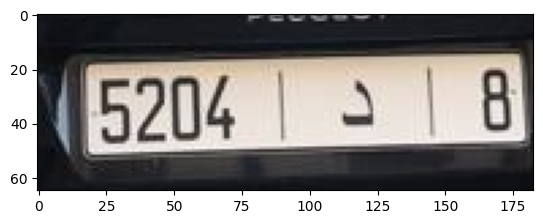

In [7]:
# prediccion del modelo sobre la imagen
network.setInput(blob)
predictions = network.forward(outputs)

plates = []
for layer in predictions: # predicciones de cada capa
    aux = layer
    scores = aux[:,5] # probabilidades de la clase license plates
    scores = scores >= 0.5 # solo se consideran predicciones arriba de 50%
    aux = aux[scores]
    
    if len(aux>0):
        plates += list(aux)

# se elige el candidato mas optimo
plates = np.array(plates)
ind = np.argmax(plates[:,5])
plate_info = plates[ind]

# caja considerando las dimensiones 416,416
box = plate_info[0:4] * np.array([w, h, w, h])
x_center, y_center, box_width, box_height = box.astype('int')
x_min = int(x_center - (box_width / 2))
y_min = int(y_center - (box_height / 2))

# plot de la placa
img_plate = image_input[y_min:y_min+box_height, x_min:x_min+box_width]
plt.imshow(cv2.cvtColor(img_plate, cv2.COLOR_BGR2RGB))
plt.show()

Posteriormente, se realiza el siguiente preprocesamiento a la imagen obtenida:
- Transformacion a escala de grises.
- Aplicacion de filtro Gaussiano para suavizar la imagen.
- Binarizacion de pixeles para resaltar los detalles de los caracteres en la placa.

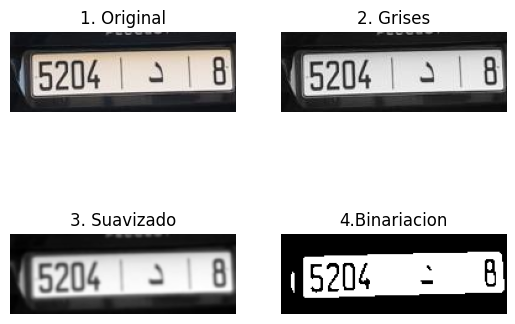

In [8]:
gray = cv2.cvtColor(img_plate, cv2.COLOR_BGR2GRAY) # transformacion a escala de grises
gauss = cv2.GaussianBlur(gray, (5,5), 0) # aplicacion de filtro gaussiano
bin_img = cv2.threshold(gauss, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1] # binarizacion

# plot
fig, axs = plt.subplots(2,2)
labels = ['1. Original', '2. Grises', '3. Suavizado', '4.Binariacion']
imgs = [cv2.cvtColor(img_plate, cv2.COLOR_BGR2RGB), gray, gauss, bin_img]
for axi, im, li in zip(axs.flat, imgs, labels):
    if li=='1. Original':
        axi.imshow(im)
    else:
        axi.imshow(im, cmap='gray')
    axi.axis('off')
    axi.set_title(li)
plt.show()

Posteriormente se usa la imagen binarizada para la extraccion de caracteres con Tesseract:

In [9]:
# identificacion de caracteres
text = pytesseract.image_to_string(bin_img, lang ='eng')
text = text.replace('\n', '') # elimina saltos de linea
text

'5204 - 8'

Finalmente se realiza el plot final, incluyendo la deteccion de la placa y el texto extraido

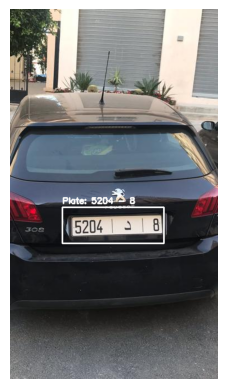

In [10]:
# color de la bounding box y texto
color = [250, 250, 250]

# bounding box
cv2.rectangle(image_input, (x_min, y_min), (x_min + box_width, y_min + box_height), color, 2)

# Texto identificado
text_box_current = f'Plate: {text}'
cv2.putText(image_input, text_box_current, (x_min, y_min - 7), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# plot
plt.imshow(cv2.cvtColor(image_input, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

## Implementacion final
Por ultimo, se realiza una implementacion final considerando todos los aspectos revisados en la seccion anterior, y se incluyen ejemplos del uso de la clase implementada.

In [11]:
# librerias necesarias
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pytesseract

class DetectionModel:
    def __init__(self):
        # configuracion de pytesseract
        pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'

        # configuracion del modelo
        weights_path = 'yolo_v4/yolov4-obj.weights'
        configuration_path = 'yolo_v4/yolov4-obj.cfg'
        self.network = cv2.dnn.readNetFromDarknet(configuration_path, weights_path)

        # nombres de las 3 capas de prediccion, cada una enfocada en la deteccion de objetos
        # en escala: pequeno, mediano y grande
        self.outputs = ['yolo_139', 'yolo_150', 'yolo_161']
    
    def predict(self, image_input, color=[255, 255, 255], font_scale=0.5):
        h, w = image_input.shape[0:2] # dimensions de la imagen
        # Normalizacion, redimension 416, 416 e intercambio de canales Red y Blue
        blob = cv2.dnn.blobFromImage(image_input, 1 / 255.0, (416, 416), swapRB=True, crop=False)

        # prediccion del modelo sobre la imagen
        self.network.setInput(blob)
        predictions = self.network.forward(self.outputs)

        plates = []
        for layer in predictions: # predicciones de cada capa
            aux = layer
            scores = aux[:,5] # probabilidades de la clase license plates
            scores = scores >= 0.5 # solo se consideran predicciones arriba de 50%
            aux = aux[scores]
            
            if len(aux>0):
                plates += list(aux)

        # se elige el candidato mas optimo
        plates = np.array(plates)
        ind = np.argmax(plates[:,5])
        plate_info = plates[ind]

        # caja considerando las dimensiones 416,416
        box = plate_info[0:4] * np.array([w, h, w, h])
        x_center, y_center, box_width, box_height = box.astype('int')
        x_min = int(x_center - (box_width / 2))
        y_min = int(y_center - (box_height / 2))

        # transformacion de la placa
        img_plate = image_input[y_min:y_min+box_height, x_min:x_min+box_width]
        gray = cv2.cvtColor(img_plate, cv2.COLOR_BGR2GRAY) # transformacion a escala de grises
        gauss = cv2.GaussianBlur(gray, (5,5), 0) # aplicacion de filtro gaussiano
        bin_img = cv2.threshold(gauss, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1] # binarizacion

        # identificacion de caracteres
        text = pytesseract.image_to_string(bin_img, lang ='eng')
        text = text.replace('\n', '') # elimina saltos de linea

        # bounding box
        cv2.rectangle(image_input, (x_min, y_min), (x_min + box_width, y_min + box_height), color, 2)

        # Texto identificado
        text_box_current = f'Plate: {text}'
        cv2.putText(image_input, text_box_current, (x_min, y_min - 7), cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, 2)

        return cv2.cvtColor(image_input, cv2.COLOR_BGR2RGB), text
        

texto en la placa: 5204 - 8


<function matplotlib.pyplot.show(close=None, block=None)>

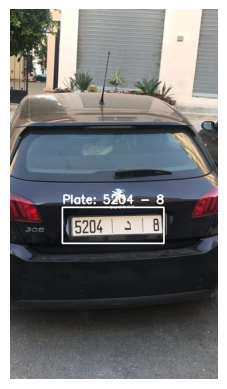

In [12]:
# instancia de la clase
test = DetectionModel()

# lectura de imagen
image_input = cv2.imread('imgs/car1.jpg') 
img, text = test.predict(image_input, color=[255,255,255], font_scale=0.7)
print(f'texto en la placa: {text}')

# plot
plt.imshow(img)
plt.axis('off')
plt.show

texto en la placa: 29003 Lil 17,


<function matplotlib.pyplot.show(close=None, block=None)>

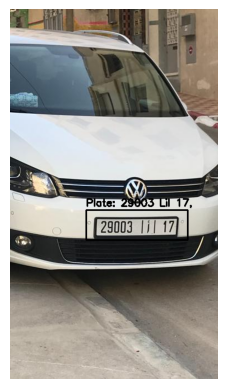

In [13]:
# instancia de la clase
test = DetectionModel()

# lectura de imagen
image_input = cv2.imread('imgs/car2.jpg') 
img, text = test.predict(image_input, color=[0,0,0], font_scale=0.6)
print(f'texto en la placa: {text}')

# plot
plt.imshow(img)
plt.axis('off')
plt.show

texto en la placa: TPT- 156-8)


<function matplotlib.pyplot.show(close=None, block=None)>

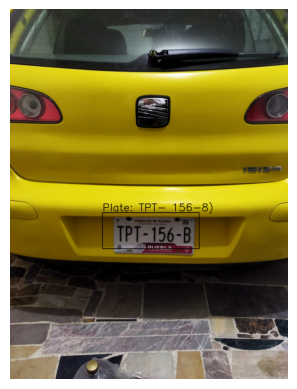

In [14]:
# instancia de la clase
test = DetectionModel()

# lectura de imagen
image_input = cv2.imread('imgs/car3.jpeg') 
img, text = test.predict(image_input, color=[0,0,0], font_scale=1.5)
print(f'texto en la placa: {text}')

# plot
plt.imshow(img)
plt.axis('off')
plt.show